In [1]:
from dotenv import load_dotenv
import os
import sys

sys.path.append('../')

load_dotenv()

config = {
    "base_url": os.getenv("BASE_URL"),
    "client_id": os.getenv("CLIENT_ID"),
    "client_secret": os.getenv("CLIENT_SECRET")
}


In [2]:
from app.agents.invoices_extractor import InvoicesExtractor, InvoiceType

extractor = InvoicesExtractor()
data = extractor.extract('2021-01-01', '2027-12-31', InvoiceType.INFLOW)


In [3]:
from app.agents.anomaly_detector import AnomalyDetector

anomaly_detector = AnomalyDetector()

output = anomaly_detector.detect(data)

In [4]:
output

DetectionOutput(anomalies=[Anomaly(date='2024-01-14', total_amount=218196.0, invoice_type='Egreso', reason='Significant increase in total amount compared to previous days.'), Anomaly(date='2024-01-24', total_amount=149039.0, invoice_type='Traslado', reason='Unusually high total amount indicating a potential anomaly.'), Anomaly(date='2025-01-29', total_amount=220874.0, invoice_type='Traslado', reason='Marked increase in total amount compared to prior days.'), Anomaly(date='2024-11-09', total_amount=211109.0, invoice_type='Egreso', reason='Notable spike in total amount suggesting an anomaly.')])

In [22]:
import pandas as pd
df_anomalies = pd.DataFrame(output.model_dump()['anomalies'])

In [23]:
df_anomalies.head()

,date,total_amount,invoice_type,reason
0,2024-01-14,218196.0,Egreso,Significant increase in total amount compared ...
1,2024-01-24,149039.0,Traslado,Unusually high total amount indicating a poten...
2,2025-01-29,220874.0,Traslado,Marked increase in total amount compared to pr...
3,2024-11-09,211109.0,Egreso,Notable spike in total amount suggesting an an...


In [24]:
df_anomalies['invoice_type']

0      Egreso
1    Traslado
2    Traslado
3      Egreso
Name: invoice_type, dtype: object

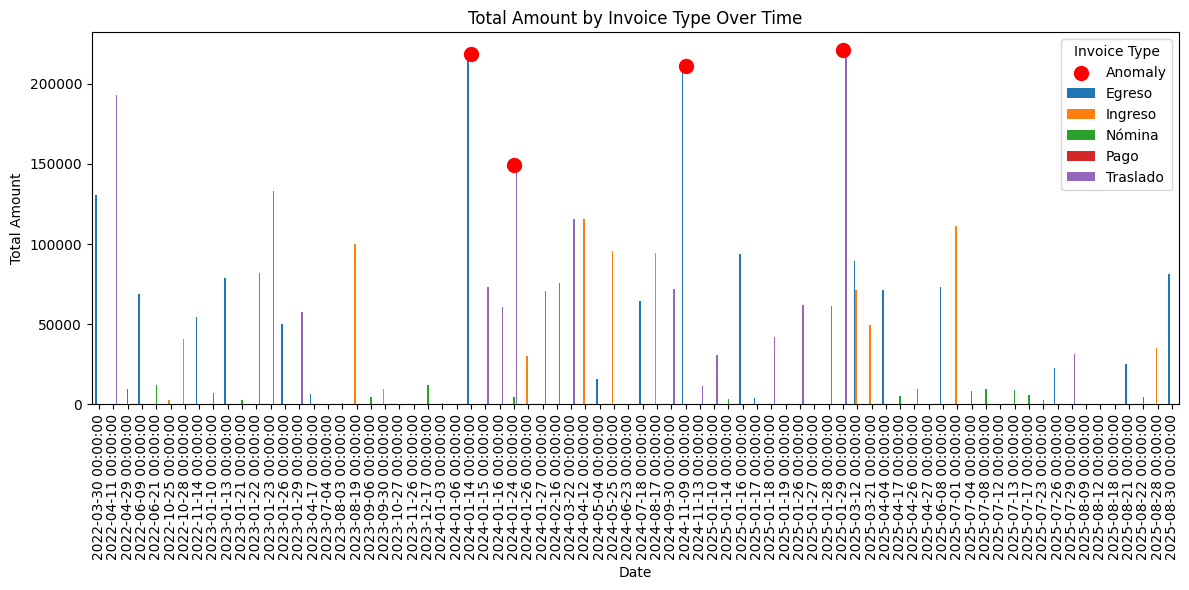

In [25]:
import matplotlib.pyplot as plt
import pandas as pd

data['date'] = pd.to_datetime(data['date'])
pivot = data.pivot_table(index='date', columns='invoice_type', values='total_amount', aggfunc='sum')

fig, ax = plt.subplots(figsize=(12, 6))
pivot.plot(kind='bar', stacked=False, ax=ax)

# Mark anomalies with a point (avoid duplicate legend entries)
anomaly_plotted = False
if not df_anomalies.empty:
    anomaly_dates = pd.to_datetime(df_anomalies['date'])
    anomaly_amounts = df_anomalies['total_amount']
    anomaly_types = df_anomalies['invoice_type']
    for anomaly_date, anomaly_amount, anomaly_type in zip(anomaly_dates, anomaly_amounts, anomaly_types):
        if anomaly_date in pivot.index and anomaly_type in pivot.columns:
            ax.scatter(
                x=pivot.index.get_loc(anomaly_date),
                y=anomaly_amount,
                color='red',
                marker='o',
                s=100,
                label='Anomaly' if not anomaly_plotted else "",
                zorder=5
            )
            anomaly_plotted = True

# Remove duplicate 'Anomaly' from legend if present
handles, labels = ax.get_legend_handles_labels()
seen = set()
new_handles, new_labels = [], []
for h, l in zip(handles, labels):
    if l not in seen:
        new_handles.append(h)
        new_labels.append(l)
        seen.add(l)
ax.legend(new_handles, new_labels, title='Invoice Type')

plt.xlabel('Date')
plt.ylabel('Total Amount')
plt.title('Total Amount by Invoice Type Over Time')
plt.tight_layout()
plt.show()


In [34]:
from langchain_core.tools import tool
from langchain_openai import ChatOpenAI
from langgraph.graph import StateGraph, END
from langgraph.prebuilt import ToolNode
from typing import TypedDict, List, Dict, Any, Annotated
from langgraph.graph.message import add_messages
import json
import sys
import os

# Add the app directory to the path
#sys.path.append('../')

# Import your custom classes
from app.agents.invoices_extractor import InvoicesExtractor
from app.agents.models.invoice_type_input import InvoiceType

@tool
def extract_invoices(date: str, invoice_type: InvoiceType):
    """
    Extract invoices for a given date and invoice type.

    Args:
        date (str): The date for which to extract invoices (format: YYYY-MM-DD).
        invoice_type (str): The type of invoice to extract (INFLOW or OUTFLOW).

    Returns:
        str: A JSON string containing the extracted invoices for the specified date and type.
    """
    try:
        
        
        extractor = InvoicesExtractor()
        df = extractor.get_invoices(date, invoice_type)
        
        # Convert to JSON string
        return df.to_json(orient='records', date_format='iso')
    except Exception as e:
        return f"Error extracting invoices: {str(e)}"

# Define the state schema using the new pattern
class State(TypedDict):
    messages: Annotated[list, add_messages]
    anomalies: List[Dict[str, Any]]

# Initialize tools and model
tools = [extract_invoices]
tool_node = ToolNode(tools)
model = ChatOpenAI(model="gpt-4o-mini", temperature=0).bind_tools(tools)

def chatbot(state: State):
    """Main chatbot function."""
    return {"messages": [model.invoke(state["messages"])]}

def should_continue(state: State):
    """Determine whether to continue or end."""
    messages = state['messages']
    last_message = messages[-1]
    
    # If the last message has tool calls, continue to tools
    if last_message.tool_calls:
        return "tools"
    # Otherwise, end
    return END

# Create the graph
graph_builder = StateGraph(State)

# Add nodes
graph_builder.add_node("chatbot", chatbot)
graph_builder.add_node("tools", tool_node)

# Add edges
graph_builder.add_conditional_edges(
    "chatbot",
    should_continue,
    {"tools": "tools", END: END}
)
graph_builder.add_edge("tools", "chatbot")

# Set entry point
graph_builder.set_entry_point("chatbot")

# Compile the graph
graph = graph_builder.compile()

def run_financial_analysis(anomalies_data, invoices_type):
    """
    Run the financial analysis agent on anomalies data.
    
    Args:
        anomalies_data: List of anomaly dictionaries from your detection system
    
    Returns:
        dict: The final state containing the analysis
    """
    
    # Create the initial message
    anomalies_text = json.dumps(anomalies_data, indent=2)
    
    initial_message = f"""You are a financial analyst. You have access to tools to extract invoice data.

Your task is to analyze the following anomaly:

{anomalies_text}

For each anomaly:
1. Use the extract_invoices with param type {invoices_type} to get the invoice data 
2. Analyze the data to understand why it's anomalous
3. Provide insights and recommendations

Please start by extracting the invoice data for each anomaly date."""

    # Run the graph
    final_state = graph.invoke({
        "messages": [("human", initial_message)],
        "anomalies": anomalies_data
    })
    
    return final_state



In [35]:
for an in output.model_dump()['anomalies']:
    print(an["date"])

2024-01-14
2024-01-24
2025-01-29
2024-11-09


In [36]:
output.model_dump()['anomalies'][-1]

{'date': '2024-11-09',
 'total_amount': 211109.0,
 'invoice_type': 'Egreso',
 'reason': 'Notable spike in total amount suggesting an anomaly.'}

In [37]:
result = run_financial_analysis(output.model_dump()['anomalies'][-1], InvoiceType.INFLOW.value)

In [38]:
result

{'messages': [HumanMessage(content='You are a financial analyst. You have access to tools to extract invoice data.\n\nYour task is to analyze the following anomaly:\n\n{\n  "date": "2024-11-09",\n  "total_amount": 211109.0,\n  "invoice_type": "Egreso",\n  "reason": "Notable spike in total amount suggesting an anomaly."\n}\n\nFor each anomaly:\n1. Use the extract_invoices with param type INFLOW to get the invoice data \n2. Analyze the data to understand why it\'s anomalous\n3. Provide insights and recommendations\n\nPlease start by extracting the invoice data for each anomaly date.', additional_kwargs={}, response_metadata={}, id='3dc66a15-916c-4952-8f59-ad3a5c6c1b99'),
  AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_R9L1Z05rDizHarjRQVJgPREX', 'function': {'arguments': '{"date":"2024-11-09","invoice_type":"INFLOW"}', 'name': 'extract_invoices'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 26, 'prompt_tokens': 247

In [39]:
from IPython.display import Markdown, display
display(Markdown(result['messages'][-1].content))

### Analysis of Anomaly on 2024-11-09

#### Extracted Invoice Data
The extracted invoice data for the date 2024-11-09 indicates a total amount of **211,108.67** with the following details:

- **Invoice Type**: Egreso (Outflow)
- **Sender**: Emisor 3F81
- **Receiver**: Receptor C49C
- **Tax Amount**: 29,405.19
- **Discount Amount**: 2,079.00
- **Subtotal Amount**: 183,782.48

#### Breakdown of Invoice Details
The invoice consists of several line items related to "Servicios de mensajería" (messaging services) with varying quantities and amounts:

1. **Line Item 1**: 
   - Quantity: 9
   - Total Amount: 59,627.54
   - Description: Messaging services for Product B53C

2. **Line Item 2**: 
   - Quantity: 6
   - Total Amount: 48,183.24
   - Description: Messaging services for Product 196B

3. **Line Item 3**: 
   - Quantity: 7
   - Total Amount: 70,525.53
   - Description: Messaging services for Product 9919

4. **Line Item 4**: 
   - Quantity: 1
   - Total Amount: 6,373.65
   - Description: Messaging services for Product 57DF

5. **Line Item 5**: 
   - Quantity: 5
   - Total Amount: 28,477.71
   - Description: Messaging services for Product 8388

#### Insights and Analysis
1. **Notable Spike**: The total amount of **211,108.67** is significantly higher than typical inflow amounts for similar services. This suggests either an unusually high volume of services rendered or potentially inflated pricing.

2. **Service Volume**: The quantities of services provided (9, 6, 7, 1, and 5) indicate a substantial engagement, but the total amount raises questions about the pricing structure. 

3. **Tax Implications**: The tax amount of **29,405.19** is also considerable, indicating that the services are subject to a high tax rate, which may be a factor in the overall spike.

4. **Discounts**: The presence of a discount amounting to **2,079.00** suggests that the original pricing was even higher, which could indicate a pricing strategy that may need to be reviewed.

#### Recommendations
1. **Review Pricing Strategy**: Conduct a thorough review of the pricing for the services rendered. Ensure that the pricing aligns with market standards and does not lead to inflated invoices.

2. **Analyze Service Demand**: Investigate the demand for messaging services during this period. If there was a legitimate spike in demand, consider adjusting capacity and pricing strategies accordingly.

3. **Monitor Future Invoices**: Implement a monitoring system for future invoices to identify any similar anomalies early on. This can help in maintaining financial integrity and operational efficiency.

4. **Engage with Stakeholders**: Communicate with the service providers and clients involved to understand the context of this spike. This can provide insights into whether this is a one-time occurrence or a trend that needs addressing.

5. **Tax Compliance Check**: Ensure that all tax calculations are accurate and compliant with regulations to avoid potential legal issues.

By addressing these areas, the organization can better manage its financial health and mitigate risks associated with such anomalies.